In [1]:
import numpy as np
import pandas as pd

import wrangle as w
import explore as e
import modeling as m
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt 

# Project Overview:
### Advancement in tornado casualty limiting technologies has made significant progress. These advancements include imporoved warning systems, updated building codes, public education, research, and community response. But how much are they helping?

### Following the Data Science pipeline, we will discover if these advancements have made an effect on casualties due to tornadoes.

# Goals:

* Acquire the data
* Prepare the data 
* Explore the data to find drivers of our target variable (casualties)
* Build time-series models to forecast drivers of caualties
* Validate, and then test our best model
* Deliver findings to a group of fellow data scientists

# Importing and Preparing Data

* data was originally aquired from https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021
* the dataframe contains 67558 rows and 12
* zero rows were removed in cleaning
* 3 redundant columns were removed
* 2 were added, casualties and cas_per_mile
* columns renamed for readability

In [2]:
df, train, test = w.wrangle_tornado_data()

### A look at the data:

In [3]:
train.head()

,state,ef,injuries,fatalities,s_lat,s_lon,e_lat,e_lon,length,width,casualties,cas_per_mile
date,,,,,,,,,,,,
1950-01-03,IL,3,3,0,39.10,-89.30,39.12,-89.23,3.6,130,3,0.83
1950-01-03,MO,3,3,0,38.77,-90.22,38.83,-90.03,9.5,150,3,0.32
1950-01-03,OH,1,1,0,40.88,-84.58,0.00,0.00,0.1,10,1,10.00
1950-01-13,AR,3,1,1,34.40,-94.37,0.00,0.00,0.6,17,2,3.33
1950-01-25,IL,2,0,0,41.17,-87.33,0.00,0.00,0.1,100,0,0.00


In [4]:
train.shape

(54046, 12)

## Data Dictionary:

| Feature | Description |
| ------ | ----|
| state | U.S. State that the tornado touched-down in|
| ef | The Enhanced Fujita Rating of the tornado|
| injuries | Number of injuries do to the the tornado |
| fatalities | The amount of fatilities due to the tornado |
| s_lat | The latitude in decimal degrees of touchdown |
| s_lon | The longitude in decimal degrees of touchdown |
| e_lat | The latitude in decimal degrees of dissipation |
| e_lon | The longitude in decimal degrees of dissipation |
| length | The length of track in miles |
| width | The width of the tornado track in yards |
| casualties | The total of number of casualties (injuries + fatalities) |
| cas_per_mile | The total of number of casualties per mile of tornado travel |

## The Enhanced Fujita Scale (EF) Table:


| Rating | Wind Speed | Damage               |
|--------|-----------|---------------------|
| EF0    | 65–85 mph | Light damage         |
| EF1    | 86–110 mph| Moderate damage      |
| EF2    | 111–135 mph| Considerable damage |
| EF3    | 136–165 mph| Severe damage        |
| EF4    | 166–200 mph| Devastating damage   |
| EF5    | >200 mph  | Incredible damage    |

# Exploration

In [5]:
df_by_month = w.get_df_by_month(df)
train_by_month, test_by_month = w.split_data(df_by_month, train_size=0.8)
y = train_by_month.casualties

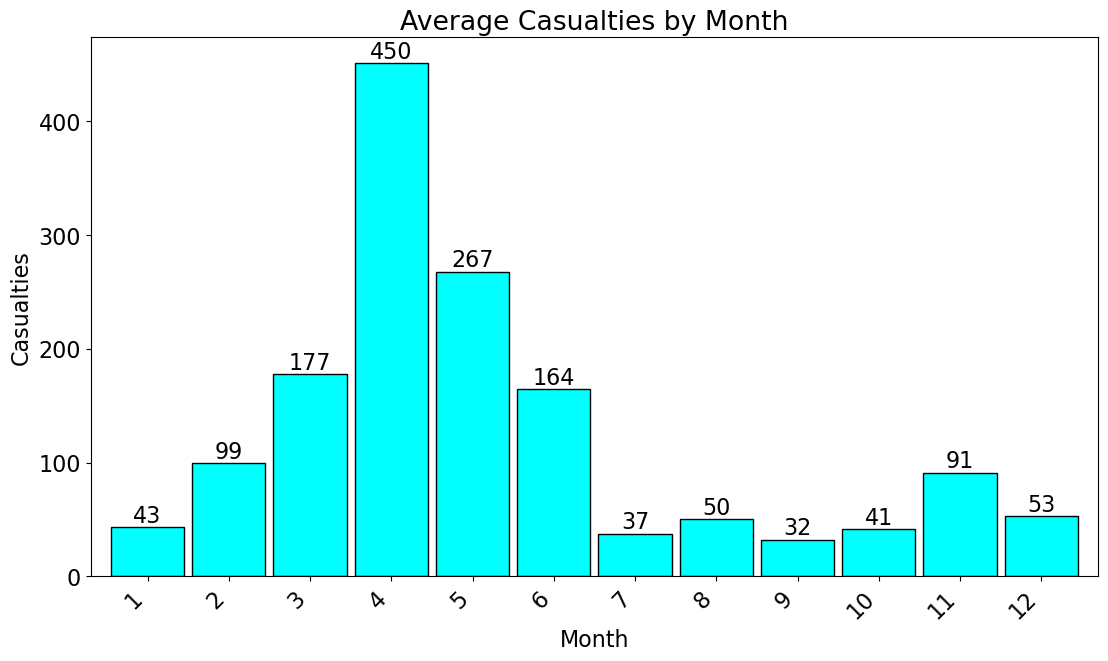

In [6]:
e.get_monthly_avg_vis(y)

**Takeaways**

Here we see averge casualties by month. April is clearly the most dangerous month for tonado casualties, last summer, fall, and winter months are much lower in terms of casualty count.

In [7]:
df_by_year = w.get_df_by_year(df)
train_by_year, test_by_year = w.split_data(df_by_year, train_size=0.8)

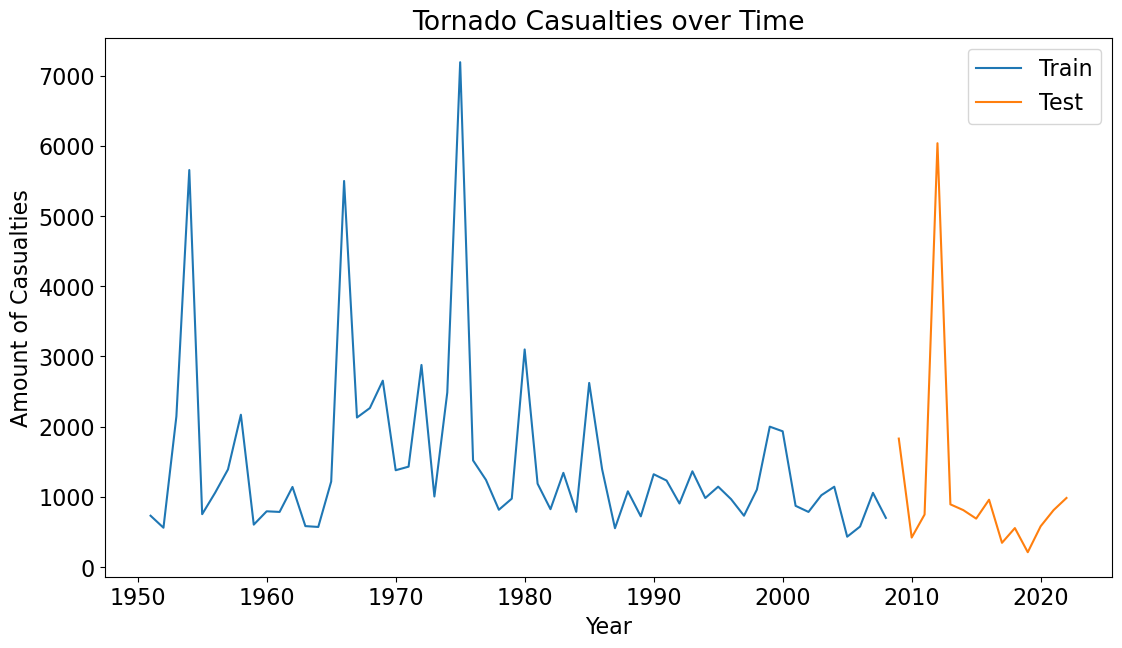

In [8]:
e.show_cas_over_time(train_by_year, test_by_year)

**Takeaways**

Visualized here is our data split of the target variable, casualties. We can see that since 1950, regardless of all the advancement, we still have relatively consistant casualty spikes with a slight lull between 1980 and 2011. 

In [9]:
df_by_decade = w.get_df_by_decade(df)

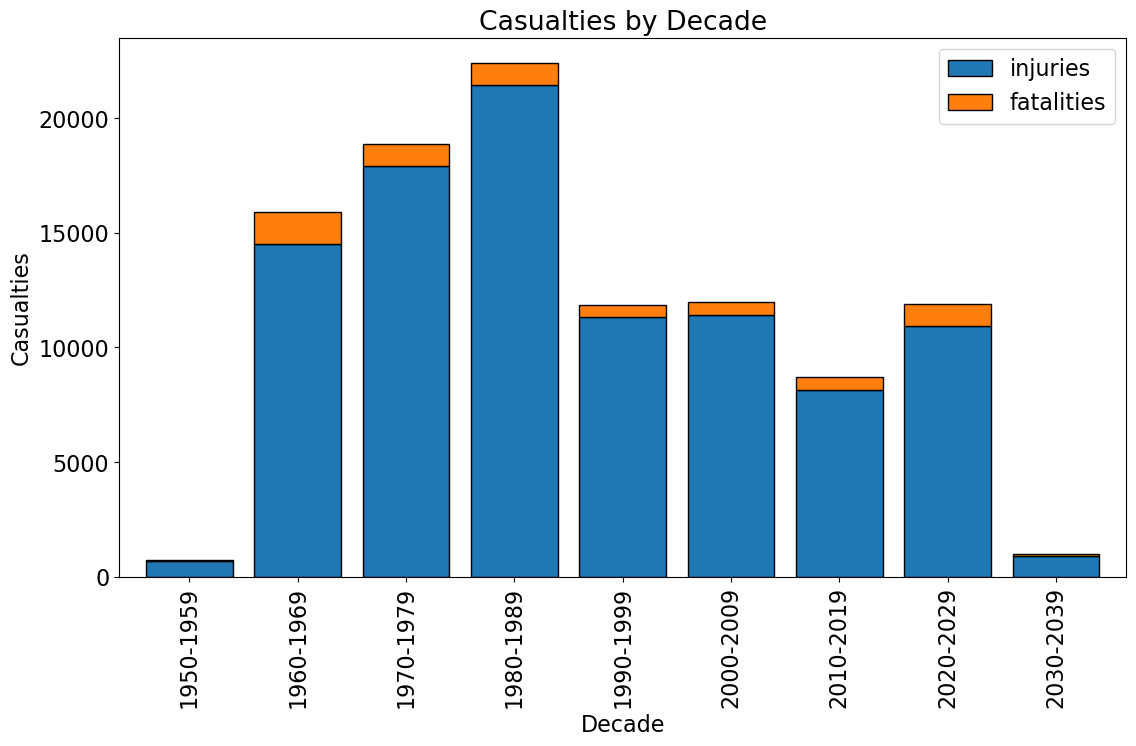

In [10]:
e.get_cas_decade_vis(df_by_decade)

**Takeaways**

We can see that the biggest reduction was from the 80's to the 90's, but not much significant improvement after that.

# Modeling
* Additional preperation was required for modeling:
    * We will be looking at the data by year moving forward
    * We will split df_by_decade into train, validate, test

In [11]:
train, validate, test =  m.mod_tts(df_by_year)

### Baseline

In [12]:
yhat_df = m.get_simple_average(train, validate)
yhat_df.head(3)

,casualties
date,
1986-12-31,1800.5
1987-12-31,1800.5
1988-12-31,1800.5


casualties -- RMSE: 850


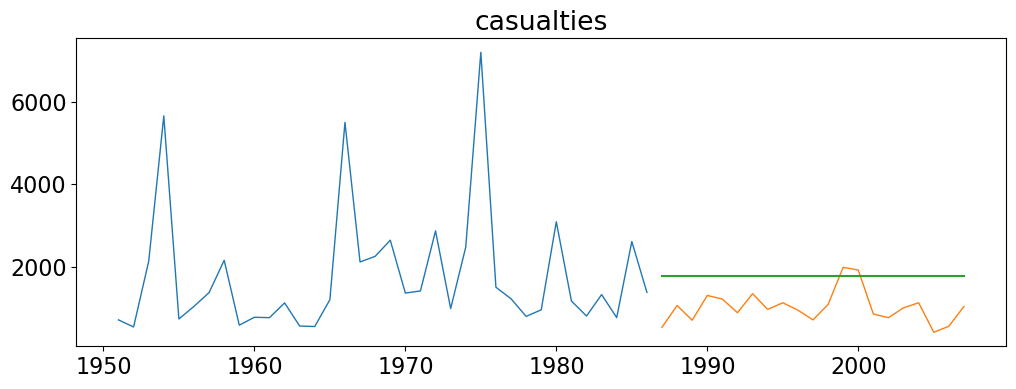

In [13]:
m.plot_and_eval('casualties', train, validate, yhat_df)

In [14]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [15]:
eval_df = m.append_eval_df(model_type='simple_average', target_var = 'casualties', 
                           validate=validate, yhat_df=yhat_df, eval_df=eval_df)
eval_df

,model_type,target_var,rmse
0,simple_average,casualties,850.0


In [16]:
yhat_df = m.get_lov(train, validate)
yhat_df.head()

,casualties
date,
1986-12-31,1393
1987-12-31,1393
1988-12-31,1393
1989-12-31,1393
1990-12-31,1393


casualties -- RMSE: 521


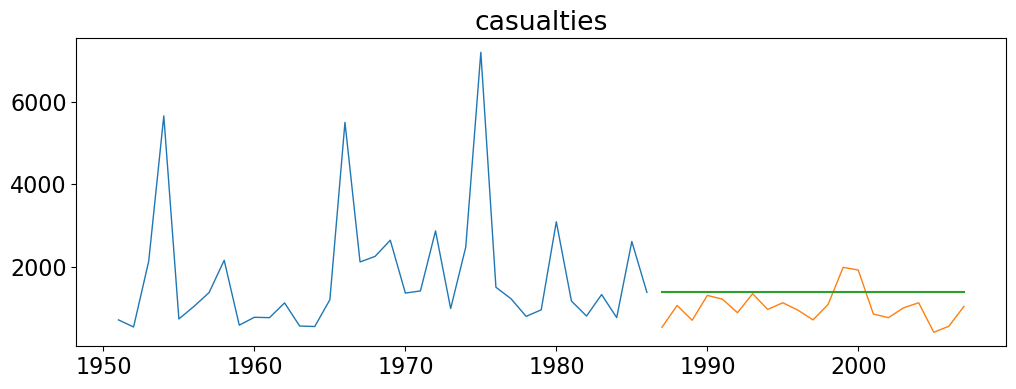

In [17]:
m.plot_and_eval('casualties', train, validate, yhat_df)

In [18]:
eval_df = m.append_eval_df(model_type='last_observed_value', target_var = 'casualties', 
                           validate=validate, yhat_df=yhat_df, eval_df=eval_df)
eval_df

,model_type,target_var,rmse
0,simple_average,casualties,850.0
1,last_observed_value,casualties,521.0


## Non-Baseline Models

In [19]:
yhat_df, model = m.get_hlt_results(train, validate, yhat_df)
yhat_df.head()

,casualties
date,
1986-12-31,1567.81
1987-12-31,1530.61
1988-12-31,1493.79
1989-12-31,1457.33
1990-12-31,1421.24


casualties -- RMSE: 465


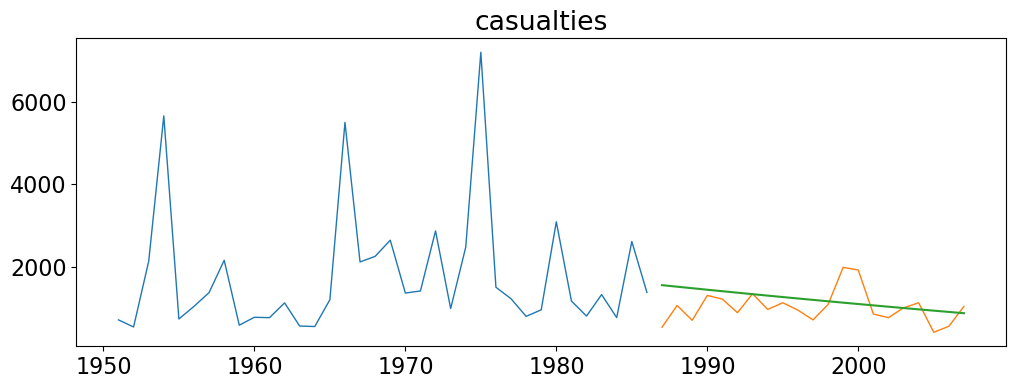

In [20]:
m.plot_and_eval('casualties', train, validate, yhat_df)

In [21]:
eval_df = m.append_eval_df(model_type='holts_optimized', target_var = 'casualties', 
                           validate=validate, yhat_df=yhat_df, eval_df=eval_df)
eval_df

,model_type,target_var,rmse
0,simple_average,casualties,850.0
1,last_observed_value,casualties,521.0
2,holts_optimized,casualties,465.0


In [22]:
hst_results, hst_cas_fit8 = m.get_hst_results(train)
hst_results

,model,SSE
7,hst_cas_fit8,7.887160e+07
5,hst_cas_fit6,8.003168e+07
6,hst_cas_fit7,8.586787e+07
4,hst_cas_fit5,8.628895e+07
0,hst_cas_fit1,8.765932e+07
1,hst_cas_fit2,8.941110e+07
2,hst_cas_fit3,9.099922e+07
3,hst_cas_fit4,9.283729e+07


hst_cas_fit8 was our best hst model - we will evalute this one

In [23]:
yhat_df = pd.DataFrame({'casualties': hst_cas_fit8.forecast(validate.shape[0] + 1)},
                          index=validate.index)

casualties -- RMSE: 1650


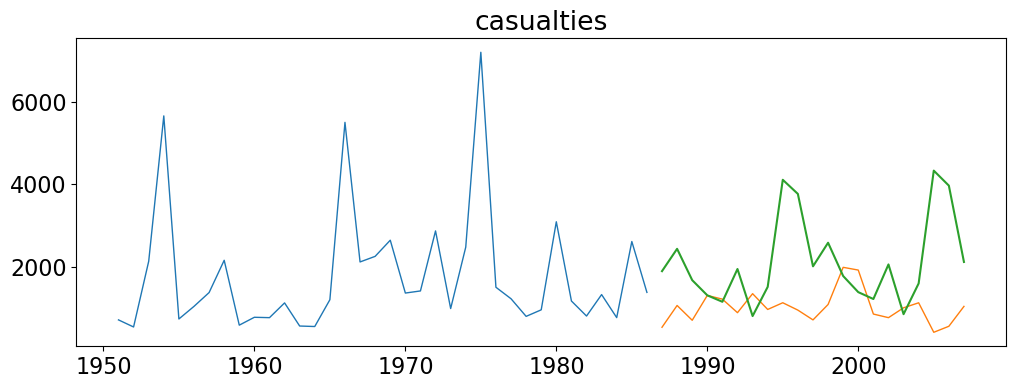

In [24]:
m.plot_and_eval('casualties', train, validate, yhat_df)

** Takeaways **

We can see here the volatitlty of the train data is severly impacting  the hst model's ability to predict casualties. 

In [25]:
eval_df = m.append_eval_df(model_type='holts_seasonal', target_var = 'casualties', 
                           validate=validate, yhat_df=yhat_df, eval_df=eval_df)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
2,holts_optimized,casualties,465.0
1,last_observed_value,casualties,521.0
0,simple_average,casualties,850.0
3,holts_seasonal,casualties,1650.0


holts_optimized was our best performing model - we will move this model into testing

## Test

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse- casualty total:  1412.1702296788585


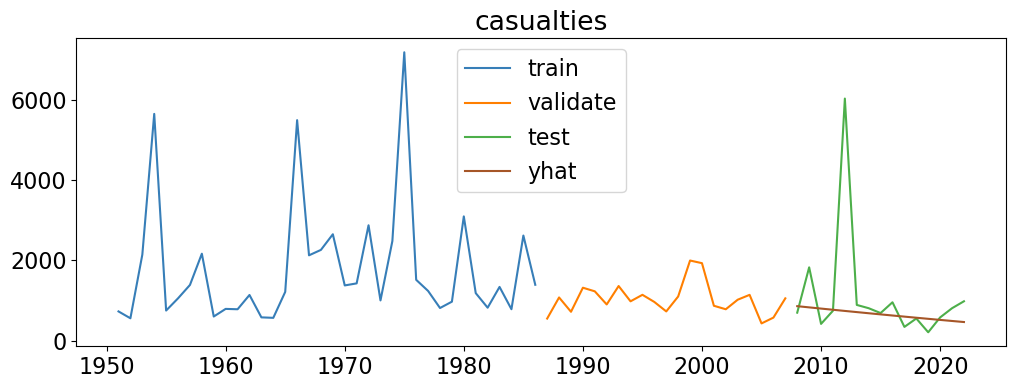

In [26]:
yhat_df = pd.DataFrame({'casualties': model.forecast(validate.shape[0] + test.shape[0] + 1)})
# test data starts on 2007-12-31, we can slice that portion from yhat_df.
yhat_df = yhat_df['2007-12-31':'2021-12-31']
m.get_test_results('casualties', train, validate, test, yhat_df)

In [27]:
# We can see the model performed poorly on the test data because of the major outlier of 2011. 
# We will address the outlier and re-run the model to understand the effect the 2011 Super-Outbreak
# has on the predictability here. 
test.casualties.sort_values(ascending=False).head(1)

date
2011-12-31    6036
Name: casualties, dtype: int64

FINAL PERFORMANCE OF MODEL ON MODIFIED TEST DATA
rmse- casualty total:  354.6396947151407


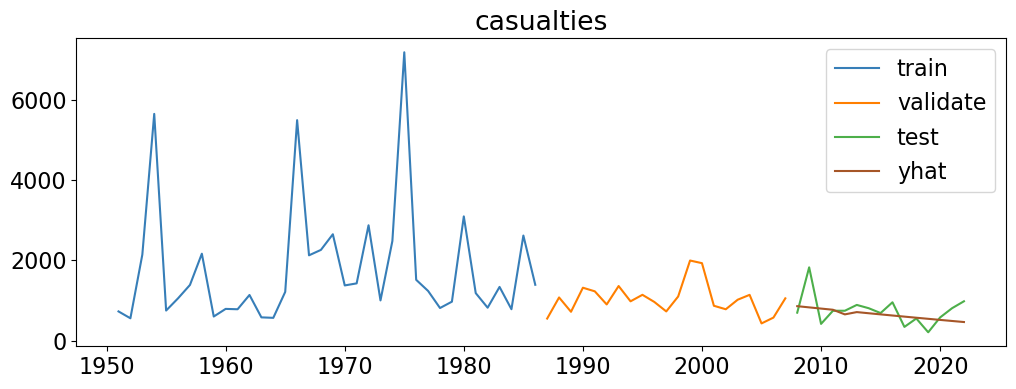

In [28]:
m.get_mod_test_reslts('casualties', train, validate, test, yhat_df)

With 2011 removed, we see our predictions follows the test data trend nicely.

## Conclusion

* Without removing the vast outlier that is 2011 casualties, we are not able to build a model that out-performs the baseline RMSE. With that year removed, we are able to reduce RMSE by **32%**.


* This shows us that despite the efforts and advancements to mitigate tornado casualties, there not much that can help hedge against the wrath of mother nature during an event like the *2011 Super Outbreak*. **On April 27th alone**, **216** tornadoes touched down in the US, with **4** being rated at EF5- we average less than **1** tornado of this magnitude per year.


* Finding the silver lining here, outside of that devistating outbreak in 2011, we do see a decline in casualties, & I'm confident that casualty mitigation efforts have been succesful. 

## Recommendations:

* We need to continue advancement in early warning technologies and public awareness. As we can see within the scope of this project, sometimes the only way to mitigate casualties is to get out of the tornado's way. If we can more accurately pin-point the path and ef rating of tornados, we can have a more effective response similar to a hurricane evacuation. 


## Next Steps:

* With more time, I would like to conduct this analysis but break the original dataset into subsets for each EF rating, then compare to see how accurately we can predict future casualties among different levels of damage potential. I believe this will reinforce my conclusion that our efforts in casualty mitigation have been succesful, but not much can help us when EF-4s and -5s are touching down.   

#### Sources: 
 - https://celebrating200years.noaa.gov/magazine/tornado_forecasting/#research
 - https://en.wikipedia.org/wiki/2011_Super_Outbreak